# Spectral analysis code

Spectral analysis of high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 31/08/2024

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import os, h5py, time, gc
import scipy.integrate
from joblib import Parallel, delayed
%matplotlib widget

## Import images

In [2]:
# data to analyse
filename="/Users/dduke/Desktop/sampleImaging/mountPoint_extinction.h5"

SPATIAL_RES=1
SAMPLE_RATE=1e5

In [3]:
with h5py.File(filename,'r') as H:
    for G in H.values():
        if isinstance(G,h5py.Group):
            print(G)
            t = G['time_frames'][...]
            x = G['x_pixel'][...]
            y = G['y_pixel'][...]
            b = G['bkgnd'][...]
            data = G['I'][...]
            if 'SPATIAL_RES' in G.attrs: SPATIAL_RES = G.attrs['SPATIAL_RES']
            if 'SAMPLE_RATE' in G.attrs: SAMPLE_RATE = G.attrs['SAMPLE_RATE']
            break # take 1st data set.

print("Loaded", data.shape, data.dtype)

<HDF5 group "/frames_11399_29999" (5 members)>
Loaded (18600, 408, 384) float32


## Flip images left-to-right
This step should be customised depending on the camera orientation
For example, rotation could be required in some cases.

In [6]:
# Flip all the images so the spray is L->R
data = np.flip(data,axis=2)
b = np.flip(b,axis=1) # same to background so it plots the same
gc.collect();

## Masking unwanted regions of the image

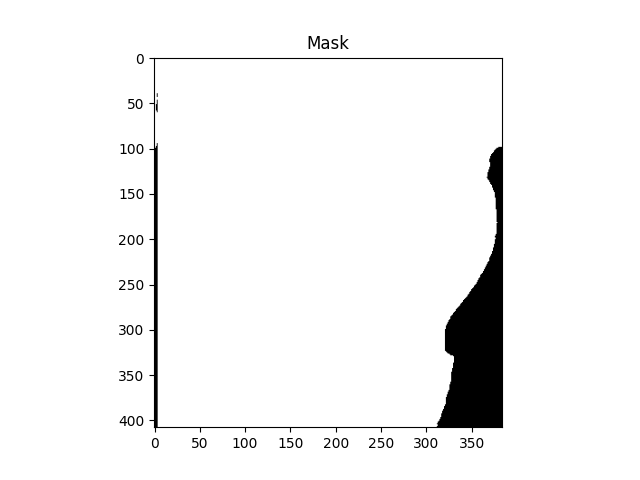

In [4]:
# Mask dark regions of background
mask = b > 10000
plt.figure();
plt.imshow(mask,cmap='grey');
plt.title("Mask");

In [5]:
# Permanently apply the mask
import tqdm
for i in tqdm.tqdm(range(data.shape[0])):
    data[i,...] = data[i,...] * mask

100%|██████████████████████████████████████████████████████████████████████████| 18600/18600 [00:38<00:00, 481.70it/s]


## Check sample images
Check masking and intensity range are sane

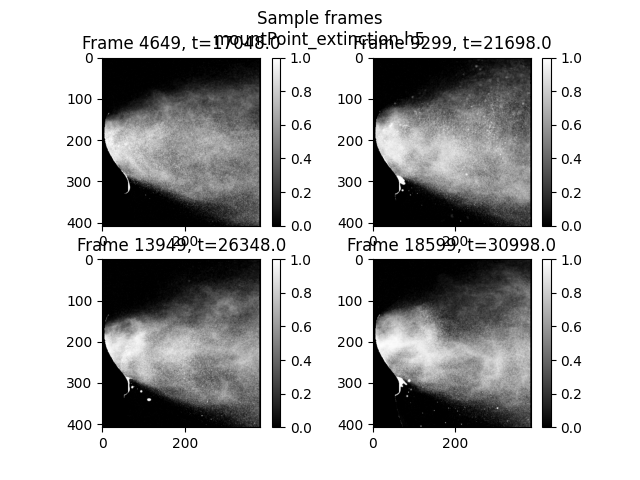

In [7]:
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(filename))
some_frames = np.linspace(0,data.shape[0]-1,5)[1:]; i=0
for n in some_frames:
    ax=fig.add_subplot(221+i)
    h=ax.imshow(data[int(n),...],cmap=plt.cm.gray,vmin=0,vmax=1)
    plt.title("Frame %i, t=%.1f" % (n,t[int(n)]))
    plt.colorbar(h);
    i+=1
gc.collect();

## Calculate temporal statistics
Get time-average image, etc, which will be useful later on.

In [8]:
# This manual way uses far less memory than NumPy's approach.
timeAvImg = np.zeros_like(data[0,...])
meansqImg  = np.zeros_like(data[0,...])
N = float(data.shape[0])
for i in range(N):
    timeAvImg += data[i,...]/N
    meansqImg += (data[i,...]**2)/N
stdevImg = np.sqrt(meansqImg - timeAvImg**2)

# Inefficient for very large data...:
#timeAvImg = np.nanmean(data,axis=0)
#stdevImg = np.nanstd(data,axis=0)

KeyboardInterrupt: 

In [ ]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
h=ax.imshow(timeAvImg,vmin=0,vmax=1,cmap='jet')
plt.title("Time-average")
plt.colorbar(h);

ax=fig.add_subplot(122)
h=ax.imshow(stdevImg,vmin=0,vmax=0.2,cmap='jet')
plt.title("Temporal Standard Deviation")
plt.colorbar(h);

# Run the Welch Method
Time-Windowed Fourier Transform with detrending and Hann window with overlapping

In [ ]:
# Apply Welch's method and then make contour plots of the results.
from scipy.signal import welch

nfft=2048

print("Welch spectra:")
print(" - Ratio samples to N FFT points = %f" % (data.shape[0]/(nfft/2)))

def welchFun(I):
    return welch(I, fs=SAMPLE_RATE,\
               window='hann', nperseg=nfft, noverlap=nfft/16, nfft=nfft, detrend='linear',\
               return_onesided=True, scaling='density', axis=0, average='mean')
    #return np.array(I.shape), I.nbytes/1024./1024.

output = Parallel(n_jobs=-1,verbose=10)(delayed(welchFun)(data[:,i,...]) for i in range(data.shape[1]))

### Restructure the output
- The spectra go into Pxx[y][t,x]  which is a list of 2d arrays
- The frequency vector is f

- Use meshgrid to make 2D arrays of x and f for contour waterfall plots

In [ ]:
f = output[0][0]
Pxx = [ output[i][1] for i in range(len(output)) ]
del output
print(" - Frequency range = %f - %f Hz" % (f[1],f[-1]))

# Make x and f vectors for plotting
xx,ff=np.meshgrid(range(Pxx[0].shape[1]),f)
xx*=SPATIAL_RES

## Transverse averaging
flatten everything in the Y axis.

This could involve masking out regions of the flow if required but in this case I just add up _all_ the spectra for each column and save into a single matrix 'zz'

In [ ]:
zz = np.zeros_like(Pxx[0])
for i in range(len(Pxx)):
    zz += np.nan_to_num(Pxx[i])
zz /= float(i)
print("Y-averaged data range:",zz.min(),zz.max())

## Remove the background spectrum
Compare all spectra to a reference one.
- This removes any spectral influence from the light source, vibration of the camera, etc.
- In cavitation experiments, placing the reference spectrum upstream removes influence of incoming flow.

In [ ]:
# Take average of some positions.
ref_y = (5,75)
ref_x = (5,75)

# Loop averaging in Y
bkgnd_spectrum = np.zeros_like(Pxx[0][:,0])
for i in range(ref_y[0],ref_y[1]):
    # Average in X
    bkgnd_spectrum += np.nanmean( Pxx[i][:,ref_x[0]:ref_x[1]], axis=1 )
bkgnd_spectrum /= abs(float(ref_y[1]-ref_y[0]))

# Normalise
integral = scipy.integrate.simpson(bkgnd_spectrum,x=f)
bkgnd_spectrum /= integral

# Show me where the reference is obtained
fig=plt.figure();
ax=fig.add_subplot(121)
h=ax.imshow(timeAvImg,cmap=plt.cm.gray,vmin=0,vmax=1)
rect = matplotlib.patches.Rectangle((ref_x[0], ref_y[0]), ref_x[1]-ref_x[0], ref_y[1]-ref_y[0],\
                                    linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title("Reference Spectrum ROI");

ax=fig.add_subplot(122)
ax.loglog(f,bkgnd_spectrum,label='Reference')
ax.loglog(f,np.nanmean(zz,axis=1),label='Average of all')
plt.xlabel('Frequency (Hz)');
plt.legend();

In [ ]:
# Save result,to zz2
zz2 = np.zeros_like(zz)
for x_ in range(zz.shape[1]):
    zz2[:,x_] = zz[:,x_] / bkgnd_spectrum
print(zz.min(),zz.max())

In [ ]:
# Make graphs
fig=plt.figure()
ax=fig.add_subplot(111)

vmin=0; vmax=zz.max()/10.

h=ax.pcolormesh(xx,ff,zz,cmap=plt.cm.gnuplot,shading='nearest',vmin=vmin,vmax=vmax)
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$P_{II}$')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE));

vmin=vmax/1e1

fig=plt.figure()
ax=fig.add_subplot(111)
logzz = np.log10(zz * (zz>1e-15) + 1e-15)
h=ax.pcolormesh(xx,ff,logzz,cmap=plt.cm.gnuplot,shading='nearest',vmin=np.log10(vmin),vmax=np.log10(vmax))
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$log_{10}(P_{II})$',extend='min')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - Log Intensity');

In [ ]:
# Plot some selected FFTs

fig=plt.figure()
ax=fig.add_subplot(111)
n=0 # loop counter
xpos = np.arange(100,x.max()-10,20) # positions

cm = plt.cm.jet#gnuplot

for x_ in xpos: 
    #label='x=%i $\mu$m' % (x)
    p=ax.semilogx(f, zz[:,int(x_/SPATIAL_RES)], label=None,\
                c=cm(float(n)/float(len(xpos))), lw=1)
    n+=1

#plt.ylim(10,)
plt.grid(alpha=.2)
plt.axvline(50,ls='--',c='k',lw=1,label='50Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$P_{II}$')
plt.legend();

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(xpos.min(), xpos.max()))

plt.colorbar(sm,ax=ax,label=r'Streamwise (X) Position');

In [ ]:
# Make x and f vectors for plotting
xx,ff=np.meshgrid(range(Pxx[0].shape[1]),f)
xx*=SPATIAL_RES

# Make graphs
fig=plt.figure()
ax=fig.add_subplot(111)

vmin=0; vmax=zz2.max()/5

h=ax.pcolormesh(xx,ff,zz2,cmap=plt.cm.gnuplot,shading='nearest',vmin=vmin,vmax=vmax)
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$P_{II}$')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - %.2f ms window' % (1e3*.5*nfft/SAMPLE_RATE));

vmin=vmax/1e1

fig=plt.figure()
ax=fig.add_subplot(111)
logzz = np.log10(zz2 * (zz2>1e-15) + 1e-15)
h=ax.pcolormesh(xx,ff,logzz,cmap=plt.cm.gnuplot,shading='nearest',vmin=np.log10(vmin),vmax=np.log10(vmax))
ax.set_yscale('log')
plt.ylim(f[f>0].min(),f.max())
plt.colorbar(h,label=r'$log_{10}(P_{II})$',extend='min')
plt.ylabel('Frequency (Hz)')
plt.xlabel(r'Streamwise position')
plt.title('Welch PSD - Log Intensity');

In [ ]:
# Plot some selected FFTs

fig=plt.figure()
ax=fig.add_subplot(111)
n=0 # loop counter
xpos = np.arange(100,x.max()-10,20) # positions

cm = plt.cm.jet#gnuplot

for x_ in xpos: 
    #label='x=%i $\mu$m' % (x)
    p=ax.semilogx(f, zz2[:,int(x_/SPATIAL_RES)], label=None,\
                c=cm(float(n)/float(len(xpos))), lw=1)
    n+=1

#plt.ylim(10,)
plt.grid(alpha=.2)
plt.axvline(50,ls='--',c='k',lw=1,label='50Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$P_{II}$')
plt.legend();

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(xpos.min(), xpos.max()))

plt.colorbar(sm,ax=ax,label=r'Streamwise (X) Position');